# Implementing an Autoencoder in PyTorch
[Implementing an Autoencoder in PyTorch](https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/?ref=lbp)

使用卷积层，构建一个自动编码器

In [21]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import sys
import torch.nn as nn

print("Python版本信息:")
print(sys.version)

print("torch版本信息:")
print(torch.__version__)

print("python路径:")
print(sys.executable)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

Python版本信息:
3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
torch版本信息:
1.13.1+cu117
python路径:
/opt/anaconda3/envs/sd-webui/bin/python
device cuda


In [22]:
batch_size_train = 32 # We use a small batch size here for training
batch_size_test = 32 #
latent_dim = 9

# define how image transformed
image_transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                             ])
#image datasets
train_dataset = datasets.MNIST('dataset/', train=True, download=True,transform=image_transform)
test_dataset = datasets.MNIST('dataset/', train=False, download=True,transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True)

In [23]:
class AE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
    def forward(self, x):
        en = self.encoder(x)
        de = self.decoder(en)
        return de

In [24]:
model = AE()
model.cuda()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

In [27]:
epochs = 30
outputs = []

for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        # x = x.reshape(-1, 28*28)
        
        reconstructed = model(x)
        
        loss = loss_function(reconstructed, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\ttotal loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss))
        
    outputs.append((epochs, x, reconstructed))   
    
torch.save(model.state_dict(), './conv_autoencoder.pth')   

Train Epoch: 0 [0/60000 (0%)]	total loss: 0.110681
Train Epoch: 0 [16000/60000 (27%)]	total loss: 51.013605
Train Epoch: 0 [32000/60000 (53%)]	total loss: 101.751419
Train Epoch: 0 [48000/60000 (80%)]	total loss: 151.989149
Train Epoch: 1 [0/60000 (0%)]	total loss: 0.097460
Train Epoch: 1 [16000/60000 (27%)]	total loss: 50.059144
Train Epoch: 1 [32000/60000 (53%)]	total loss: 99.587415
Train Epoch: 1 [48000/60000 (80%)]	total loss: 149.204314
Train Epoch: 2 [0/60000 (0%)]	total loss: 0.094830
Train Epoch: 2 [16000/60000 (27%)]	total loss: 49.334472
Train Epoch: 2 [32000/60000 (53%)]	total loss: 98.281034
Train Epoch: 2 [48000/60000 (80%)]	total loss: 147.101941
Train Epoch: 3 [0/60000 (0%)]	total loss: 0.097430
Train Epoch: 3 [16000/60000 (27%)]	total loss: 48.593341
Train Epoch: 3 [32000/60000 (53%)]	total loss: 97.000992
Train Epoch: 3 [48000/60000 (80%)]	total loss: 145.509683
Train Epoch: 4 [0/60000 (0%)]	total loss: 0.090416
Train Epoch: 4 [16000/60000 (27%)]	total loss: 48.085324

In [36]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

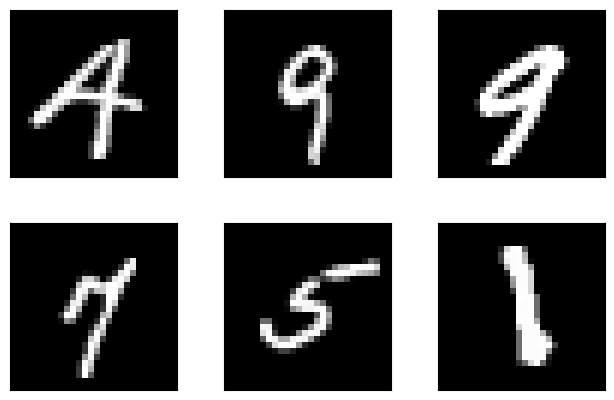

In [35]:
item = to_img(x)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  # item = x[i].reshape(-1, 28, 28)
  plt.imshow(item[i][0].cpu().numpy(), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  

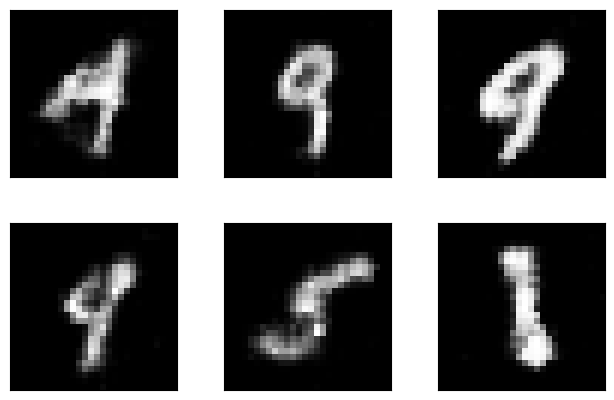

In [33]:
item = to_img(reconstructed)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  
  plt.imshow(item[i][0].cpu().detach().numpy(), cmap='gray',interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [40]:
import os
from torchvision.utils import save_image

path = './output/image'
if not os.path.exists(path):
    os.makedirs(path)

pic = to_img(reconstructed.cpu().data)
save_image(pic, path+'/image_epoch{}.png'.format(epoch))